# This notebook crops the field shapefile to only keep the part within our PRISMA raster file. 
Since our shapefile has larger geographical extension than our PRISMA raster files do, we need to crop the shapefile and only keep the part within the PRISMA raster. 

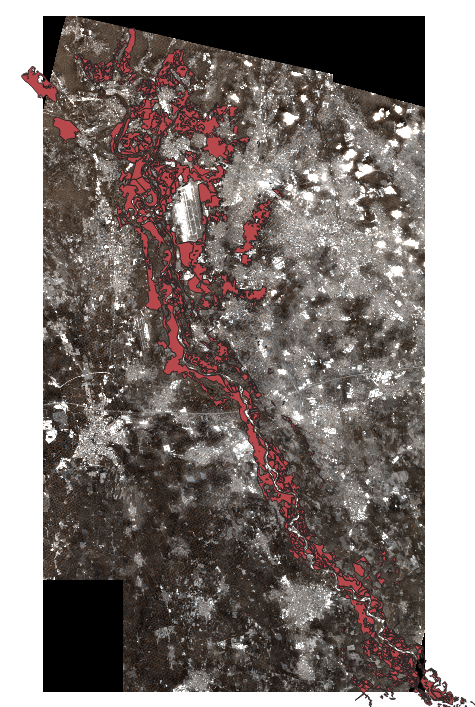

In [24]:
import os
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
# 16 Oct 2023: gdal must be imported first, and then rasterio can be imported
from osgeo import gdal
import rasterio as rio
from rasterio import features
from rasterio.plot import show

In [25]:
import rasterio2ENVIhdr

In [26]:
# Set some directories. Here we use absolute directories. 
cwd = 'c:\\Users\\m1865\\Desktop\\Ticino'
cwd_Field = cwd + '\\FieldData\\ShapefileCorrettiAggiunto'
cwd_PRISMA = cwd + "\\PRISMA Raster Raw\\Merged"
cwd_PRISMA_Mask = cwd + "\\PRISMA Raster Mask"

In [27]:
# Load our shapefile
gdf_Field = gpd.read_file(cwd_Field + "\\confini_foreste_estesi.shp")
gdf_Field

,FID,geometry
0,1,"POLYGON ((470447.573 5066242.191, 471117.870 5..."
1,2,"POLYGON ((471877.758 5067247.400, 471685.552 5..."
2,3,"POLYGON ((473242.834 5065867.946, 472965.412 5..."
3,4,"POLYGON ((484814.271 5050487.661, 484998.392 5..."
4,5,"POLYGON ((473143.615 5056493.908, 473403.450 5..."
...,...,...
1348,1341,"MULTIPOLYGON (((472282.024 5067535.856, 472282..."
1349,1342,"POLYGON ((473006.315 5068074.574, 472986.378 5..."
1350,1343,"POLYGON ((472896.079 5068110.401, 472888.674 5..."
1351,1344,"POLYGON ((472500.581 5068648.999, 472487.280 5..."


In [28]:
# Get the name of all the rasters in our folder
raster_Names = [name.split('.')[0] for name in os.listdir(cwd_PRISMA)]
raster_Names = list(set(raster_Names))
raster_Names

['PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i',
 'PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i_new',
 'PRS_L2D_STD_20220611_20220710_NS_mosaic_crop_smooth_v2i']

## Crop shapefile with the bounding box of the raster. 

Since our rasters have the same bounding box, we hereby only use one of them. 

In [29]:
# Load one of our PRISMA raster files
raster = rio.open(cwd_PRISMA + "\\" + raster_Names[0])
raster

<open DatasetReader name='c:/Users/m1865/Desktop/Ticino/PRISMA Raster Raw/Merged/PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i' mode='r'>

In [30]:
# Get the bbox of the raster file: [left,bottom,right,top]
print(raster.bounds)
raster_Left = raster.bounds[0]
raster_Bottom = raster.bounds[1]
raster_Right = raster.bounds[2]
raster_Top = raster.bounds[3]

BoundingBox(left=465450.0, bottom=5009970.0, right=499560.0, top=5070420.0)


In [31]:
# Create a polygon based on the raster extent, no spatial information yet
raster_BBox = box(raster_Left,raster_Bottom,raster_Right,raster_Top)
print(raster_BBox)

POLYGON ((499560 5009970, 499560 5070420, 465450 5070420, 465450 5009970, 499560 5009970))


In [32]:
# Convert the polygon to a shapefile polygon which covers our RoI
gdf_Raster_BBox = gpd.GeoDataFrame(
    [1],
    geometry=[raster_BBox], # Don't forget the [] which makes our polygon into a list
    crs='EPSG:32632'
)
gdf_Raster_BBox

,0,geometry
0,1,"POLYGON ((499560.000 5009970.000, 499560.000 5..."


<Axes: >

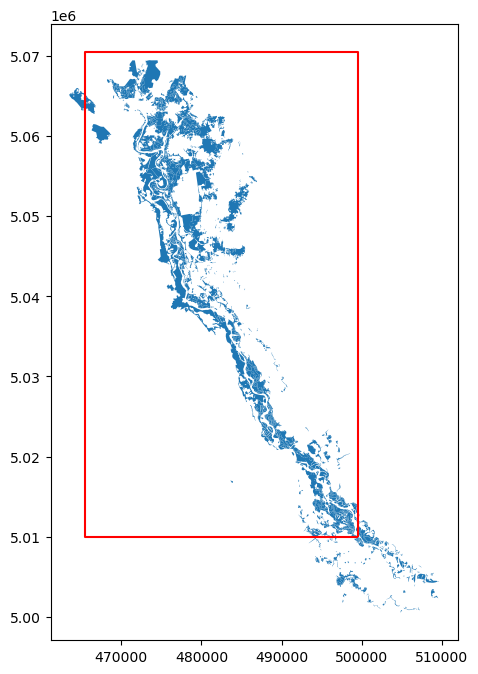

In [33]:
# Plot both the polygon (its boundary only) and the shapefile
fig, ax1 = plt.subplots(1,figsize=(12,8))
gdf_Raster_BBox.boundary.plot(ax=ax1,color='red')
gdf_Field.plot(ax=ax1)

<Axes: >

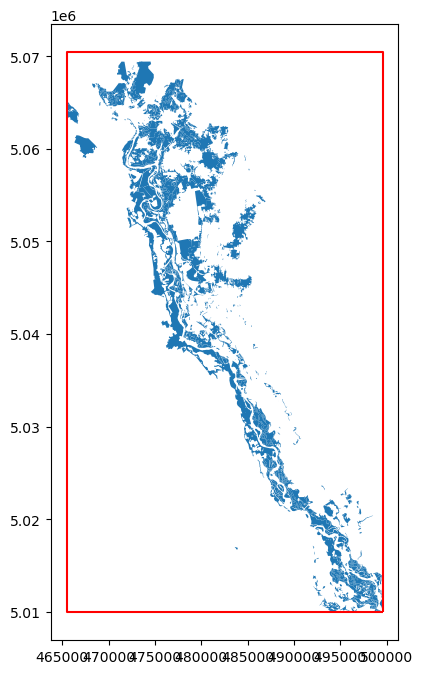

In [34]:
# Crop! 
gdf_Field_Crop = gdf_Field.clip(gdf_Raster_BBox)
# Plot to check the crop result! 
fig, ax1 = plt.subplots(1,figsize=(12,8))
gdf_Raster_BBox.boundary.plot(ax=ax1,color='red')
gdf_Field_Crop.plot(ax=ax1)

## Now we need to crop again our shapefile, removing the areas where there are no data in the PRISMA raster file. 

For this part, first we generate a mask raster by using our shapefile. So that the overlapping areas between our shapefile and our raster will be kept, and the others will be masked. 

In [35]:
list_Raster = []
for name in raster_Names:
    temp = rio.open(cwd_PRISMA + "\\" + name)
    list_Raster.append(temp)
list_Raster

[<open DatasetReader name='c:/Users/m1865/Desktop/Ticino/PRISMA Raster Raw/Merged/PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i' mode='r'>,
 <open DatasetReader name='c:/Users/m1865/Desktop/Ticino/PRISMA Raster Raw/Merged/PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i_new' mode='r'>,
 <open DatasetReader name='c:/Users/m1865/Desktop/Ticino/PRISMA Raster Raw/Merged/PRS_L2D_STD_20220611_20220710_NS_mosaic_crop_smooth_v2i' mode='r'>]

Rasterized successfully!
Rasterized successfully!
Rasterized successfully!


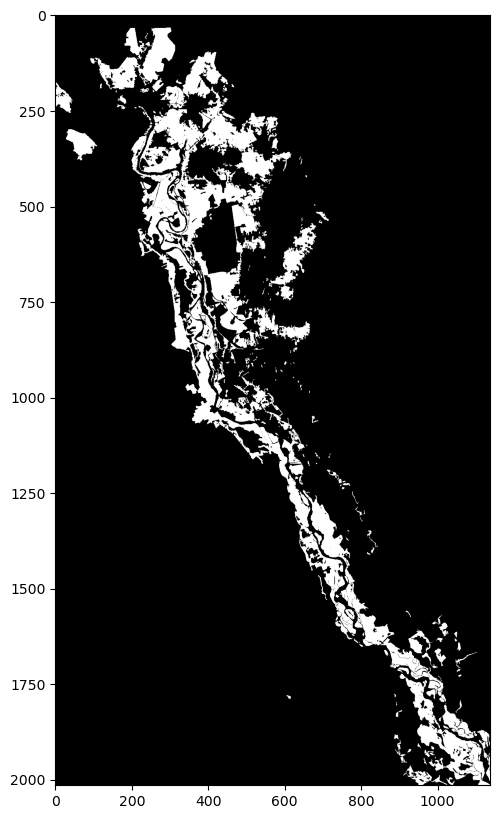

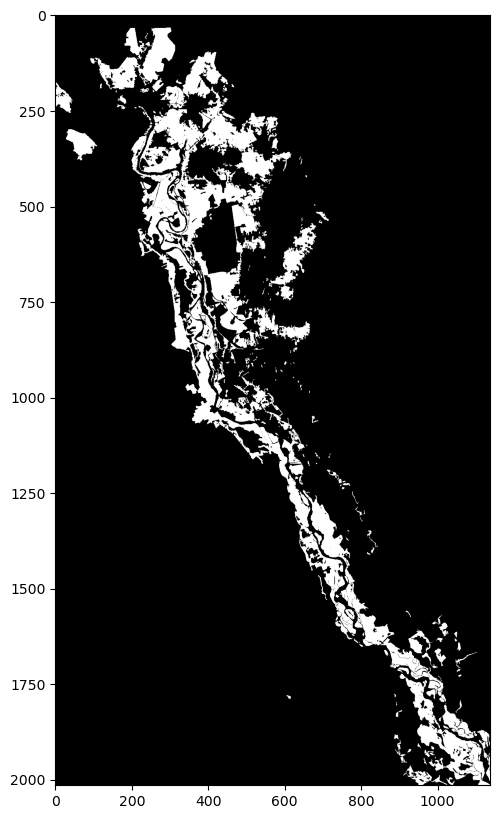

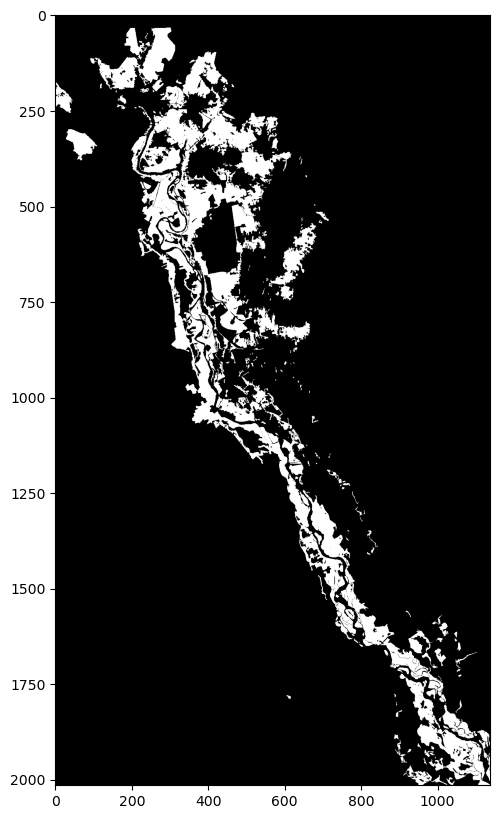

In [36]:
list_Mask_CropShp = []
for raster in list_Raster:
    mask_CropShp = features.rasterize(gdf_Field_Crop.geometry,
                                    out_shape = raster.shape,
                                    fill = 0,
                                    out = None,
                                    transform = raster.transform, # "new_Raster.transform" contains information of pixel size and affine? 
                                    all_touched = False,
                                    default_value = 1, # 
                                    dtype = None)
    print('Rasterized successfully!')
    list_Mask_CropShp.append(mask_CropShp)
    # Plot rasterized shapefile, since it will be used as a mask, then we choose colormap "Greys_r"
    fig, ax = plt.subplots(1, figsize = (10, 10))
    show(mask_CropShp, ax = ax, cmap='Greys_r')

Then, we read one band of our PRISMA raster and set it to a binary ndarray composed of either 0 or 1. After this step, we can get another mask raster, which will be used to crop the shapefile, removing the areas where there are no data in the PRISMA raster. 

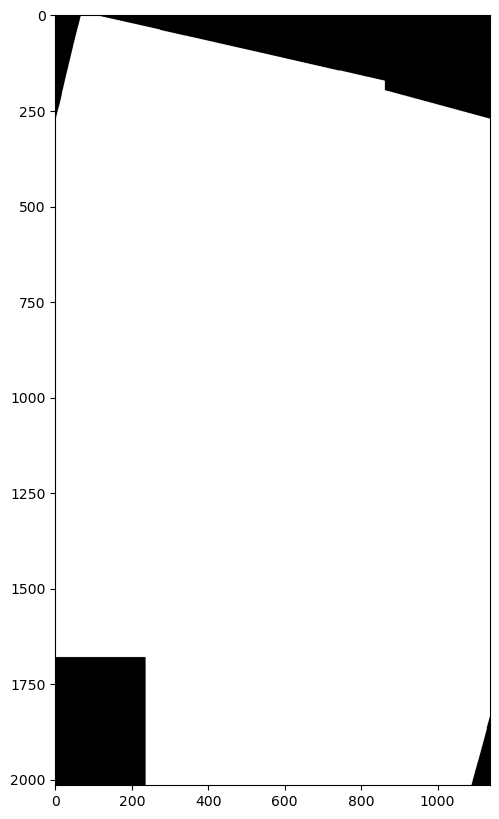

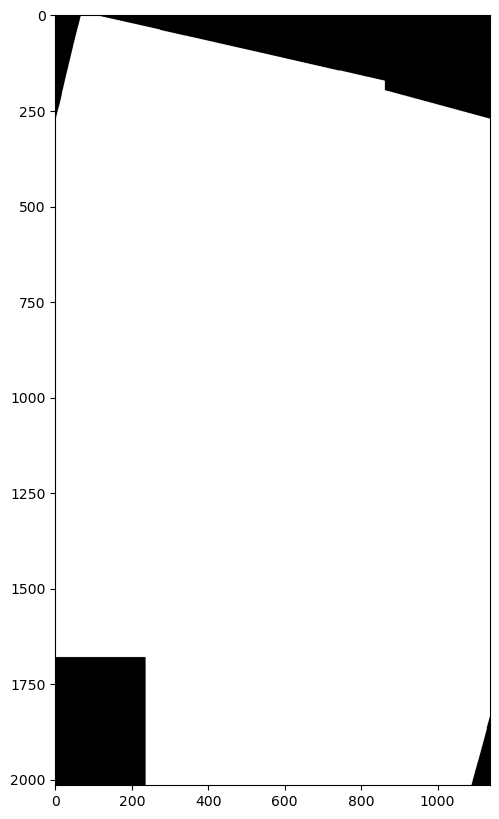

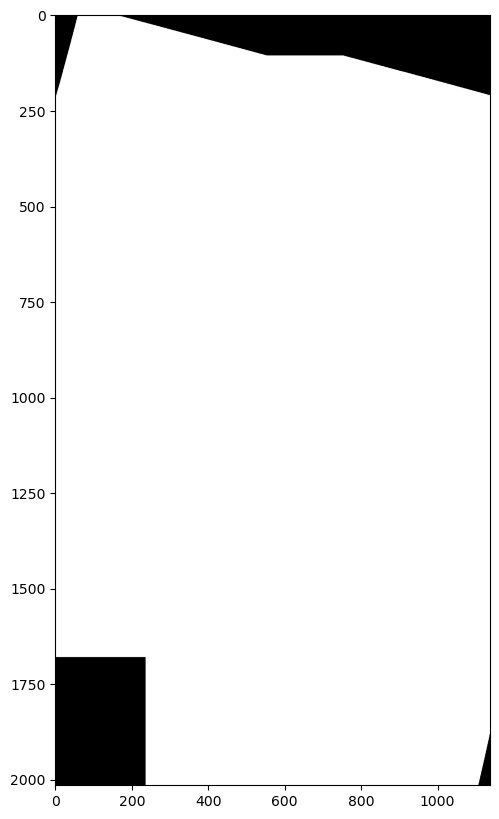

In [37]:
list_Mask_Band1 = []
for raster in list_Raster:
    mask_Band1 = raster.read(1)
    mask_Band1[mask_Band1 != 0] = 1
    list_Mask_Band1.append(mask_Band1)
    fig, ax = plt.subplots(1, figsize = (10, 10))
    show(mask_Band1, ax = ax, cmap='Greys_r')

Meanwhile we save these two "original masks" into local storage for future use. 

In [38]:
# There are some tags exclusive to ENVI header files, but "rasterio" fails to embed them. Thus we need to extract them and later create the correct ENVI header file by ourselves. 
for x in range(0,len(raster_Names)):
    # Since all the raster files have the same info regarding band names, wavelength and wavelength units, here we extract them from the first raster. 
    str_ENVI_hdr_band_names = 'band names = ' + list_Raster[x].tags(ns='ENVI')['band_names']
    str_ENVI_hdr_wavelength = 'wavelength = ' + list_Raster[x].tags(ns='ENVI')['wavelength']
    str_ENVI_hdr_wavelength_units = 'wavelength units = ' + list_Raster[x].tags(ns='ENVI')['wavelength_units']
    # We have rasterized our shapefile to a raster file, but it still has 8 bands and only the first band contains information. 
    rasterized_meta = list_Raster[x].meta
    rasterized_meta.update(
        count = 1,
    )
    # Save the rasterized shapefile
    with rio.open(cwd_PRISMA_Mask + '\\' + raster_Names[x] + ' Mask Original', "w", **rasterized_meta) as dest:
        dest.write(list_Mask_Band1[x],indexes=1)
    print(raster_Names[0] + ' Mask has been saved successfully! ')
    rasterio2ENVIhdr.rasterio2ENVIhdr(cwd_PRISMA_Mask + '\\' + raster_Names[x] + ' Mask Original.hdr', str_ENVI_hdr_band_names, str_ENVI_hdr_wavelength, str_ENVI_hdr_wavelength_units, is_Mask=True)
    print(raster_Names[0] + ' Mask.hdr has been converted to ENVI header file!')

PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i Mask has been saved successfully! 
Lines after the row 14 will be deleted!
PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i Mask.hdr has been converted to ENVI header file!
PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i Mask has been saved successfully! 
Lines after the row 14 will be deleted!
PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i Mask.hdr has been converted to ENVI header file!
PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i Mask has been saved successfully! 
Lines after the row 14 will be deleted!
PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i Mask.hdr has been converted to ENVI header file!


Now, we need to merge these two mask rasters. The black areas in the second raster must be present in the first raster. 

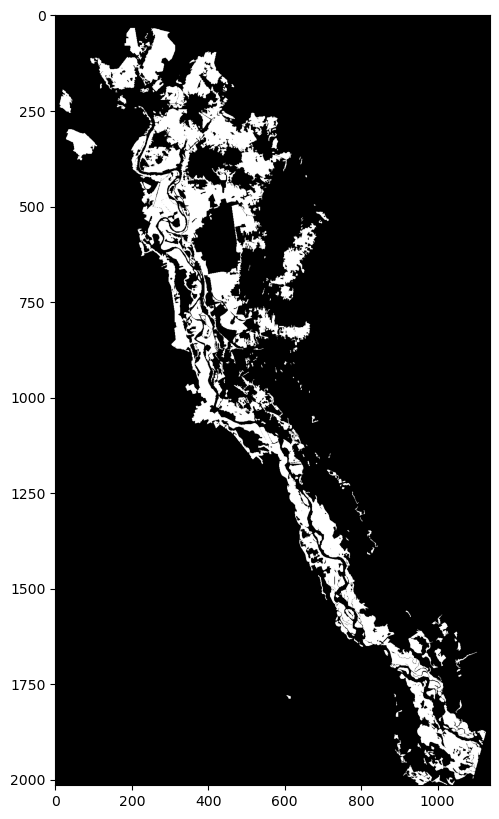

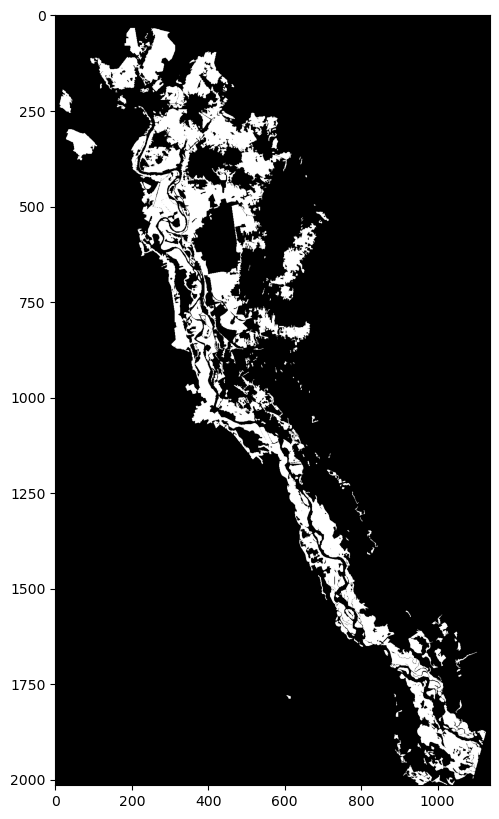

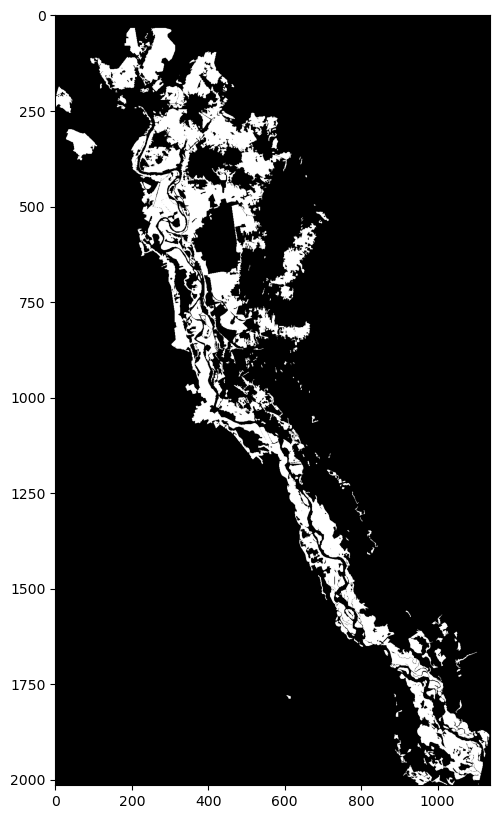

In [39]:
# Merge 3 masks into one! 
list_Mask_Merge = []
# Deep copy
for x in range(0,len(list_Mask_CropShp)):
    mask_Merge = list_Mask_CropShp[x].copy()
    # Compare each pixel and mask the first raster based on the second raster. 
    for i in range(0,list_Mask_CropShp[x].shape[0]):
        for j in range(0,list_Mask_CropShp[x].shape[1]):
            if list_Mask_CropShp[x][i,j] != list_Mask_Band1[x][i,j]:
                if list_Mask_CropShp[x][i,j] == 1:
                    mask_Merge[i,j] = 0
    list_Mask_Merge.append(mask_Merge)
    fig, ax = plt.subplots(1, figsize = (10, 10))
    show(mask_Merge, ax = ax, cmap='Greys_r')   


In [40]:
# There are some tags exclusive to ENVI header files, but "rasterio" fails to embed them. Thus we need to extract them and later create the correct ENVI header file by ourselves. 
for x in range(0,len(raster_Names)):
    # Since all the raster files have the same info regarding band names, wavelength and wavelength units, here we extract them from the first raster. 
    str_ENVI_hdr_band_names = 'band names = ' + list_Raster[x].tags(ns='ENVI')['band_names']
    str_ENVI_hdr_wavelength = 'wavelength = ' + list_Raster[x].tags(ns='ENVI')['wavelength']
    str_ENVI_hdr_wavelength_units = 'wavelength units = ' + list_Raster[x].tags(ns='ENVI')['wavelength_units']
    # We have rasterized our shapefile to a raster file, but it still has 8 bands and only the first band contains information. 
    rasterized_meta = list_Raster[x].meta
    rasterized_meta.update(
        count = 1,
    )
    # Save the rasterized shapefile
    with rio.open(cwd_PRISMA_Mask + '\\' + raster_Names[x] + ' Mask', "w", **rasterized_meta) as dest:
        dest.write(list_Mask_Merge[x],indexes=1)
    print(raster_Names[0] + ' Mask has been saved successfully! ')
    rasterio2ENVIhdr.rasterio2ENVIhdr(cwd_PRISMA_Mask + '\\' + raster_Names[x] + ' Mask.hdr', str_ENVI_hdr_band_names, str_ENVI_hdr_wavelength, str_ENVI_hdr_wavelength_units, is_Mask=True)
    print(raster_Names[0] + ' Mask.hdr has been converted to ENVI header file!')

PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i Mask has been saved successfully! 
Lines after the row 14 will be deleted!
PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i Mask.hdr has been converted to ENVI header file!
PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i Mask has been saved successfully! 
Lines after the row 14 will be deleted!
PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i Mask.hdr has been converted to ENVI header file!
PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i Mask has been saved successfully! 
Lines after the row 14 will be deleted!
PRS_L2D_STD_20220906_20220911_NS_mosaic_crop_smooth_v2i Mask.hdr has been converted to ENVI header file!
